In [1]:
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!pip install scikit-learn
!pip install tqdm
!pip install oddt
!pip install h5py

In [3]:
import htmd.ui as ht
from moleculekit.molecule import Molecule
import moleculekit.tools.voxeldescriptors as vd
from moleculekit.tools.voxeldescriptors import getVoxelDescriptors, viewVoxelFeatures
from moleculekit.tools.atomtyper import prepareProteinForAtomtyping
from moleculekit.smallmol.smallmol import SmallMol
from moleculekit.home import home
import os

import csv
from tqdm import *
import os
import pickle
import numpy as np
import pandas as ps
import multiprocessing as mp
from sklearn.model_selection import train_test_split
from oddt import toolkit
from oddt import datasets
from oddt.datasets import pdbbind

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 


Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. https://dx.doi.org/10.1021/acs.jctc.6b00049
HTMD Documentation at: https://software.acellera.com/htmd/

You are on the latest HTMD version (2.3.19+0.gc7a6bfe.dirty).



2024-08-05 13:28:08,327 - rdkit - INFO - Enabling RDKit 2023.09.6 jupyter extensions


In [4]:
data_dir = ".\DLSCORE-CNN-master\DLSCORE-CNN-master\dataset"
pdbbind_dir = os.path.join(data_dir, "refined-set-2016\\")
pdbbind_dataset = pdbbind(home = pdbbind_dir, default_set='refined', version=2016)

### Manual Functions for feature extractions

In [5]:
# (c) 2015-2018 Acellera Ltd http://www.acellera.com
# All Rights Reserved
# Distributed under HTMD Software License Agreement
# No redistribution in whole or part
#


"""
All values below are taken from PeriodicTable.C from VMD source code

van der Waals radii are taken from A. Bondi,
J. Phys. Chem., 68, 441 - 452, 1964,
except the value for H, which is taken from R.S. Rowland & R. Taylor,
J.Phys.Chem., 100, 7384 - 7391, 1996. Radii that are not available in
either of these publications have RvdW = 2.00 �.
The radii for Ions (Na, K, Cl, Ca, Mg, and Cs are based on the CHARMM27
Rmin/2 parameters for (SOD, POT, CLA, CAL, MG, CES) by default.
"""

massdict = {'Ac': 227.0, 'Ag': 107.8682, 'Al': 26.981538, 'Am': 243.0, 'Ar': 39.948, 'As': 74.9216, 'At': 210.0,
            'Au': 196.96655, 'B': 10.811, 'Ba': 137.327, 'Be': 9.012182, 'Bh': 264.0, 'Bi': 208.98038, 'Bk': 247.0,
            'Br': 79.904, 'C': 12.0107, 'Ca': 40.078, 'Cd': 112.411, 'Ce': 140.116, 'Cf': 251.0, 'Cl': 35.453,
            'Cm': 247.0, 'Co': 58.9332, 'Cr': 51.9961, 'Cs': 132.90545, 'Cu': 63.546, 'Db': 262.0, 'Ds': 271.0,
            'Dy': 162.5, 'Er': 167.259, 'Es': 252.0, 'Eu': 151.964, 'F': 18.9984032, 'Fe': 55.845, 'Fm': 257.0,
            'Fr': 223.0, 'Ga': 69.723, 'Gd': 157.25, 'Ge': 72.64, 'H': 1.00794, 'He': 4.0026, 'Hf': 178.49,
            'Hg': 200.59, 'Ho': 164.93032, 'Hs': 269.0, 'I': 126.90447, 'In': 114.818, 'Ir': 192.217, 'K': 39.0983,
            'Kr': 83.798, 'La': 138.9055, 'Li': 6.941, 'Lr': 262.0, 'Lu': 174.967, 'Md': 258.0, 'Mg': 24.305,
            'Mn': 54.938049, 'Mo': 95.94, 'Mt': 268.0, 'N': 14.0067, 'Na': 22.98977, 'Nb': 92.90638, 'Nd': 144.24,
            'Ne': 20.1797, 'Ni': 58.6934, 'No': 259.0, 'Np': 237.0, 'O': 15.9994, 'Os': 190.23, 'P': 30.973761,
            'Pa': 231.03588, 'Pb': 207.2, 'Pd': 106.42, 'Pm': 145.0, 'Po': 209.0, 'Pr': 140.90765, 'Pt': 195.078,
            'Pu': 244.0, 'Ra': 226.0, 'Rb': 85.4678, 'Re': 186.207, 'Rf': 261.0, 'Rg': 272.0, 'Rh': 102.9055,
            'Rn': 222.0, 'Ru': 101.07, 'S': 32.065, 'Sb': 121.76, 'Sc': 44.95591, 'Se': 78.96, 'Sg': 266.0,
            'Si': 28.0855, 'Sm': 150.36, 'Sn': 118.71, 'Sr': 87.62, 'Ta': 180.9479, 'Tb': 158.92534, 'Tc': 98.0,
            'Te': 127.6, 'Th': 232.0381, 'Ti': 47.867, 'Tl': 204.3833, 'Tm': 168.93421, 'U': 238.02891, 'V': 50.9415,
            'W': 183.84, 'X': 0.0, 'Xe': 131.293, 'Y': 88.90585, 'Yb': 173.04, 'Zn': 65.409, 'Zr': 91.224}

radiidict = {'Ac': 2.0, 'Ag': 1.72, 'Al': 2.0, 'Am': 2.0, 'Ar': 1.88, 'As': 1.85, 'At': 2.0, 'Au': 1.66, 'B': 2.0,
             'Ba': 2.0, 'Be': 2.0, 'Bh': 2.0, 'Bi': 2.0, 'Bk': 2.0, 'Br': 1.85, 'C': 1.7, 'Ca': 1.37, 'Cd': 1.58,
             'Ce': 2.0, 'Cf': 2.0, 'Cl': 2.27, 'Cm': 2.0, 'Co': 2.0, 'Cr': 2.0, 'Cs': 2.1, 'Cu': 1.4, 'Db': 2.0,
             'Ds': 2.0, 'Dy': 2.0, 'Er': 2.0, 'Es': 2.0, 'Eu': 2.0, 'F': 1.47, 'Fe': 2.0, 'Fm': 2.0, 'Fr': 2.0,
             'Ga': 1.07, 'Gd': 2.0, 'Ge': 2.0, 'H': 1.2, 'He': 1.4, 'Hf': 2.0, 'Hg': 1.55, 'Ho': 2.0, 'Hs': 2.0,
             'I': 1.98, 'In': 1.93, 'Ir': 2.0, 'K': 1.76, 'Kr': 2.02, 'La': 2.0, 'Li': 1.82, 'Lr': 2.0, 'Lu': 2.0,
             'Md': 2.0, 'Mg': 1.18, 'Mn': 2.0, 'Mo': 2.0, 'Mt': 2.0, 'N': 1.55, 'Na': 1.36, 'Nb': 2.0, 'Nd': 2.0,
             'Ne': 1.54, 'Ni': 1.63, 'No': 2.0, 'Np': 2.0, 'O': 1.52, 'Os': 2.0, 'P': 1.8, 'Pa': 2.0, 'Pb': 2.02,
             'Pd': 1.63, 'Pm': 2.0, 'Po': 2.0, 'Pr': 2.0, 'Pt': 1.72, 'Pu': 2.0, 'Ra': 2.0, 'Rb': 2.0, 'Re': 2.0,
             'Rf': 2.0, 'Rg': 2.0, 'Rh': 2.0, 'Rn': 2.0, 'Ru': 2.0, 'S': 1.8, 'Sb': 2.0, 'Sc': 2.0, 'Se': 1.9,
             'Sg': 2.0, 'Si': 2.1, 'Sm': 2.0, 'Sn': 2.17, 'Sr': 2.0, 'Ta': 2.0, 'Tb': 2.0, 'Tc': 2.0, 'Te': 2.06,
             'Th': 2.0, 'Ti': 2.0, 'Tl': 1.96, 'Tm': 2.0, 'U': 1.86, 'V': 2.0, 'W': 2.0, 'X': 1.5, 'Xe': 2.16, 'Y': 2.0,
             'Yb': 2.0, 'Zn': 1.39, 'Zr': 2.0}


def massByElement(element):
    try:
        return massdict[element]
    except:
        return 0.


def radiusByElement(element):
    try:
        return radiidict[element]
    except:
        return 1.5


def _getRadii(mol):
    """ Gets vdW radius for each elem in mol.element. Source VMD.

    Parameters
    ----------
    mol :
        A Molecule object. Needs to be read from Autodock 4 .pdbqt format

    Returns
    -------
    radii : np.ndarray
        vdW radius for each element in mol.
    """

    mappings = {  # Mapping pdbqt representation to element.
        'HD': 'H',
        'HS': 'H',
        'A': 'C',
        'NA': 'N',
        'NS': 'N',
        'OA': 'O',
        'OS': 'O',
        'MG': 'Mg',
        'SA': 'S',
        'CL': 'Cl',
        'CA': 'Ca',
        'MN': 'Mn',
        'FE': 'Fe',
        'ZN': 'Zn',
        'BR': 'Br',
        'CS': 'C', # Extra added
        'PB': 'P',
        # 'Pb':'P',
        # 'Cs': 'C'
    }
    atoms = ['H', 'C', 'N', 'O', 'F', 'Mg', 'P', 'S', 'Cl', 'Ca', 'Fe', 'Zn', 'Br', 'I', 'Pb', 'Cs']
    atoms.extend(['Co', 'Hg', 'Ni', 'Sr', 'Mn', 'K', 'Se', 'Cu', 'Cd', 'Li', 'Na']) # Extra added
    for el in atoms:
        #print(f'mappings[el]: {mappings[el]}')
        mappings[el] = el
        #print(el)

    res = np.zeros(mol.numAtoms)
    for a in range(mol.numAtoms):
        elem = mol.element[a]
        #print(f'elem = {elem}')

        if elem not in mappings:
            raise ValueError('PDBQT element {} does not exist in mappings.'.format(elem))
        elem = mappings[elem]
        if elem in radiidict:
            rad = radiusByElement(elem)
        else:
            print('Unknown element -', mol.element[a], '- at atom index ', a)
            rad = 1.5
        res[a] = rad
    return res

   

In [6]:
def _getGridCenters(llc, N, resolution):
    xrange = [llc[0] + resolution * x for x in range(0, N[0])]
    yrange = [llc[1] + resolution * x for x in range(0, N[1])]
    zrange = [llc[2] + resolution * x for x in range(0, N[2])]
    centers = np.zeros((N[0], N[1], N[2], 3))
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            for k, z in enumerate(zrange):
                centers[i, j, k, :] = np.array([x, y, z])
    return centers

### Hessain Matrix Generation

In [7]:
def read_pdb_file(pdb_file):
    coordinates = []
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                atom_type = line[12:16].strip()
                atom_no = line[23:27].strip()
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                b_factor = float(line[60:66])
                if (atom_type == 'CA'):
                    coordinates.append([atom_type, atom_no, x, y, z, b_factor])
    return coordinates
def build_Hessain(coordinates):
    no_of_residue = len(coordinates)
    cut_off = 18
    H = np.zeros((3*no_of_residue, 3*no_of_residue), float)
    for i in range(0, no_of_residue-1):
        cor_i = np.array(coordinates[i][2:5])
        res_i_x = i * 3
        res_i_z = res_i_x + 3
        cor_i_j = []
        p = i + 1
        for k in range(p, no_of_residue):
            temp = np.array(coordinates[k][2:5]) - cor_i
            cor_i_j.append(temp)
        cor_i_j = np.array(cor_i_j)
        for j, s_ij_2 in enumerate((np.power(cor_i_j, 2)).sum(1)):
            if s_ij_2 > (cut_off*cut_off):
                continue
            # Super element 3x3
            gamma = 1
            d_i_j = cor_i_j[j]
            j += i+1
            res_j_x = j * 3
            res_j_z = res_j_x + 3
            super_element = np.outer(d_i_j, d_i_j) * (-gamma / s_ij_2)
            H[res_i_x:res_i_z, res_j_x:res_j_z] = super_element
            H[res_j_x:res_j_z, res_i_x:res_i_z] = super_element
            H[res_i_x:res_i_z, res_i_x:res_i_z] = H[res_i_x:res_i_z, res_i_x:res_i_z] - super_element
            H[res_j_x:res_j_z, res_j_x:res_j_z] = H[res_j_x:res_j_z, res_j_x:res_j_z] - super_element

    return H


### Feature Extraction

In [8]:
def get_pdb_complex_feature(protein_file, ligand_file, pocket_file):
    """ Returns voxel features for a pdb complex """

    def get_prop(mol, left_most_point):
        """ Returns atom occupancies """
        n = [24, 24, 24] # Voxel size (size of big voxel or cube)
        
        # Get the channels
        channels = vd._getAtomtypePropertiesPDBQT(mol)
        #print(f'Cnalles = {channels}')
        sigmas = _getRadii(mol)
        #print(f'signmas = {sigmas}')
        channels = sigmas[:, np.newaxis] * channels.astype(float)
        
        # Choose the grid centers
        centers = _getGridCenters(llc = left_most_point, N = n, resolution=1)
        #print(f'centers = {centers}')
        centers = centers.reshape(np.prod(n), 3)
        
        # Extract the features and return
        features = vd._getOccupancyC(mol.coords[:, :, mol.frame], centers, channels)
        return features.reshape(*n, -1)

    def get_pocket_feature(pocket_file):
        corr = read_pdb_file(pocket_file)
        no_of_residue = len(corr)
        
        H = build_Hessain(corr)
    
        eigvals, eigvec = np.linalg.eigh(H)

        max_effect_mode = eigvec[:, -1] * eigvals[-1]

        #print(max_effect_mode.shape)

        return max_effect_mode #Basiaclly it is just a 1-D numpy array
    
    # Generate the HTMD Molecule objects
    protein_mol = Molecule(protein_file)
    ligand_mol = Molecule(ligand_file)

    left_most_point = list(np.mean(ligand_mol.coords.reshape(-1, 3), axis=0) - 12.0)
    
    # Get the features for both the protein and the ligand. Return those after concatenation.
    protein_features = get_prop(protein_mol, left_most_point)
    ligand_features = get_prop(ligand_mol, left_most_point)
    pocket_feature = get_pocket_feature(pocket_file)
    #print(pocket_feature.shape)

    protein_features_t = protein_features.transpose().reshape([8, 24, 24, 24])    
    ligand_features_t = protein_features.transpose().reshape([8, 24, 24, 24])    
    
    return np.concatenate((protein_features_t, ligand_features_t), axis=0), pocket_feature


In [9]:
def get_pdb_features(ids, sets="refined"):
    """ Returns features for given pdb ids"""
    pdb_ids = []
    pdb_features = []
    pocket_features = []

    for pdbid in tqdm(ids):
        protein_file = os.path.join(pdbbind_dir, pdbid, pdbid + "_protein.pdbqt")
        ligand_file = os.path.join(pdbbind_dir, pdbid, pdbid + "_ligand.pdbqt")
        pocket_file = os.path.join(pdbbind_dir, pdbid, pdbid + "_pocket.pdb")
        if not os.path.isfile(protein_file) or not os.path.isfile(ligand_file): 
            continue
            #print(1)
            
        try:
            features, pocket_feat = get_pdb_complex_feature(protein_file, ligand_file, pocket_file)
            #print(list(pocket_feat))
        except Exception as e:
            print("ERROR in ", pdbid , " ", str(e))
            #print(protein_file)
            continue

        #print(pdbid)
        #print(features) 
        
        pdb_ids.append(pdbid)
        pdb_features.append(features)
        pocket_features.append(list(pocket_feat))
        #print(len(pocket_features))
    
    # Convert the list of features as numpy array and return


    
    # print(len(pocket_features))
    # print(len(max(pocket_features,key = lambda x: len(x))))
    # data_x_2 = np.zeros([len(pocket_features),len(max(pocket_features,key = lambda x: len(x)))])
    # for i,j in enumerate(pocket_features):
    #     data_x_2[i][0:len(j)] = j


    pocket_features = pad_sequences(pocket_features, maxlen=256, padding='post', truncating ='post', value = 1)
    data_x_2 = np.array(pocket_features, dtype=np.float32)
    print(data_x_2.shape)
    
    data_x_1 = np.array(pdb_features, dtype=np.float32)
    data_y = np.array([pdbbind_dataset.sets[sets][_id] for _id in pdb_ids], dtype=np.float32)

    print(data_x_1.shape)
    

    return data_x_1, data_y, data_x_2


In [10]:
def get_features():
    """ Returns features for all the complexes in the dataset. """ 
    # List ids in the core set
    core_ids = list(pdbbind_dataset.sets['core'].keys())
    # List ids in the refined set
    refined_ids = list(pdbbind_dataset.sets['refined'].keys()) 
    # remove core ids from the refined set.
    refined_ids = [i for i in refined_ids if i not in core_ids]
    
    # Get the features 
    print("Extracting features for the core set")
    core_x_1, core_y, core_x_2 = get_pdb_features(core_ids, sets="core")
    print("Extracting features for the refined set")
    refined_x_1, refined_y, refined_x_2 = get_pdb_features(refined_ids)    
    
    return core_x_1, core_y, refined_x_1, refined_y, core_x_2, refined_x_2

In [11]:
import warnings
warnings.filterwarnings('ignore')
test_x_1, test_y, train_x_1, train_y, test_x_2, train_x_2 = get_features()

Extracting features for the core set


  4%|▍         | 12/290 [00:12<04:49,  1.04s/it]


KeyboardInterrupt: 

In [12]:
print(train_y.shape)
print(test_x_1.shape)
print(test_x_2.shape)
print(test_y.shape)
print(train_x_1.shape) # To pad length = 320
print(train_x_2.shape)

NameError: name 'train_y' is not defined

In [13]:
train_x_1, valid_x_1, train_x_2, valid_x_2, train_y, valid_y = train_test_split(train_x_1, train_x_2, train_y, test_size=0.2)
print("Shapes in the training, test and the validation set: ", train_x_1.shape, train_x_2.shape, valid_x_1.shape, valid_x_2.shape, test_x_1.shape, test_x_2.shape)
# x_train, x_test, y_train, y_test = train_test_split(dataset_df['Sequences'], dataset_df['class'], test_size = 0.2)

NameError: name 'train_x_1' is not defined

### Saving Extracted Features

In [ ]:
import h5py
print("Saving the data in data.h5")
h5f = h5py.File(os.path.join(data_dir, "data_1.h5"), 'w')
h5f.create_dataset('train_x_1', data=train_x_1)
h5f.create_dataset('train_x_2', data=train_x_2)
h5f.create_dataset('train_y', data=train_y)
h5f.create_dataset('valid_x_1', data=valid_x_1)
h5f.create_dataset('valid_x_2', data=valid_x_2)
h5f.create_dataset('valid_y', data=valid_y)
h5f.create_dataset('test_x_1', data=test_x_1)
h5f.create_dataset('test_x_2', data=test_x_2)
h5f.create_dataset('test_y', data=test_y)
h5f.close()

### Training and Initializing Model

In [14]:
import os
import h5py
data_dir = ".\DLSCORE-CNN-master\DLSCORE-CNN-master\dataset"
pdbbind_dir = os.path.join(data_dir, "refined-set-2016\\")
pdbbind_dataset = pdbbind(home = pdbbind_dir, default_set='refined', version=2016)
h5f = h5py.File(os.path.join(data_dir, "data_1.h5"), 'r')
train_x_1, train_y = h5f['train_x_1'][:], h5f['train_y'][:]
valid_x_1, valid_y = h5f['valid_x_1'][:], h5f['valid_y'][:]
test_x_1, test_y = h5f['test_x_1'][:], h5f['test_y'][:]
train_x_2, valid_x_2, test_x_2 = h5f['train_x_2'][:], h5f['valid_x_2'][:], h5f['test_x_2'][:]
h5f.close()
print("Data shapes: ", train_x_1.shape, valid_x_1.shape, test_x_1.shape, train_x_2.shape, valid_x_2.shape, test_x_2.shape)
print("Y shape: ", train_y.shape, valid_y.shape, test_y.shape)

Data shapes:  (2997, 16, 24, 24, 24) (750, 16, 24, 24, 24) (290, 16, 24, 24, 24) (2997, 256) (750, 256) (290, 256)
Y shape:  (2997,) (750,) (290,)


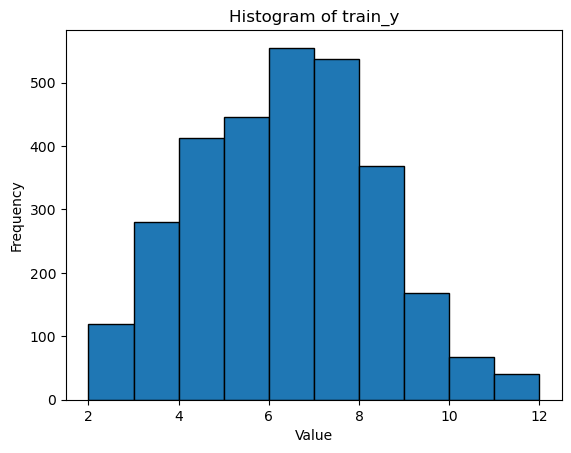

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_y is your array
# Example data, replace with your actual data

# Define the number of buckets (bins)
num_bins = 10  # You can adjust the number of bins as needed

# Create the histogram data
counts, bin_edges = np.histogram(train_y, bins=num_bins, range=(2, 12))

# Compute the bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot the bar chart
plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of train_y')

# Show the plot
plt.show()


#### Defining Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# from keras.models import Sequential,Model
# from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
# from keras.layers.convolutional import Conv3D
# from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
# from keras.initializers import he_uniform
# from keras.initializers import glorot_uniform



class ExpandBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, padding=0)
        self.conv2 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        expand1 = F.relu(self.conv1(x))
        expand2 = F.relu(self.conv2(x))
        return torch.cat([expand1, expand2], dim=1)

class CrossAttention(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq=d_out_kq
        self.W_query=nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key  = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value=nn.Parameter(torch.rand(d_in, d_out_v))
    
    def forward(self, x_1, x_2):
        queries_1=x_1.matmul(self.W_query)
        keys_2=x_2.matmul(self.W_key)
        values_2=x_2.matmul(self.W_value)
        
        attn_scores=queries_1.matmul(keys_2.T)
        attn_weights=torch.softmax(
            attn_scores/self.d_out_kq**0.5, dim=-1
        )
        
        context_vec=attn_weights.matmul(values_2)
        return context_vec



class KatNet(nn.Module):
    def __init__(self):
        super(KatNet, self).__init__()

        self.conv0 = nn.Conv3d(16, 128,kernel_size = 3, stride=2, padding = 1)
        
        self.conv1 = nn.Conv3d(128, 256, kernel_size=1, padding=1)
        self.bn1 = nn.BatchNorm3d(256)
        self.pool1 = nn.MaxPool3d(kernel_size=3, stride=2)
        self.expand_block1 = ExpandBlock(256, 64)
        
        self.conv2 = nn.Conv3d(128, 32, kernel_size=1, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=2)
        self.expand_block2 = ExpandBlock(32, 64)

        self.conv3 = nn.Conv3d(128, 32, kernel_size=1, padding=1)
        self.bn3 = nn.BatchNorm3d(32)
        self.pool3 = nn.MaxPool3d(kernel_size=3, stride=2)
        self.expand_block3 = ExpandBlock(32, 128)

        #self.avg_pool_1 = nn.AvgPool3d(kernel_size=3, padding=1)


        self.conv4 = nn.Conv3d(256, 32, kernel_size=1, padding=1)
        self.bn4 = nn.BatchNorm3d(32)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=1, padding = 1)
        self.expand_block4 = ExpandBlock(32, 128)

        self.conv5 = nn.Conv3d(256, 128, kernel_size=1, padding = 1)
        self.bn5 = nn.BatchNorm3d(128)
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=1, padding = 1)
        self.expand_block5 = ExpandBlock(128, 192)


        self.conv6 = nn.Conv3d(384, 128, kernel_size=1, padding = 1)
        self.bn6 = nn.BatchNorm3d(128)
        self.pool6 = nn.MaxPool3d(kernel_size=2, stride=1, padding = 1)
        self.expand_block6 = ExpandBlock(128, 32)

        self.conv7 = nn.Conv3d(64, 16, kernel_size=1, padding = 1)
        self.bn7 = nn.BatchNorm3d(16)
        self.pool7 = nn.MaxPool3d(kernel_size=3, stride=1)
        self.expand_block7 = ExpandBlock(16, 16)

        
        self.avg_pool_2 = nn.AvgPool3d(kernel_size=5)

        self.crossattn = CrossAttention(256, 5, 256)


        self.flatten = nn.Flatten(1) 
        
        # self.fc_1 = nn.Linear(256, 512)
        # self.fc_2 = nn.Linear(512, 720)
        # self.fc_3 = nn.Linear(720, 1028)
        # self.fc_4 = nn.Linear(1028, 512)
        self.fc_5 = nn.Linear(256, 128)
        self.fc_6 = nn.Linear(128, 32)
        self.fc_7 = nn.Linear(32, 16)
        self.fc_8 = nn.Linear(16, 1)
                

    def forward(self, x, x1):

        x = F.relu(self.conv0(x))
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool2(x)
        x = self.expand_block1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.expand_block2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.expand_block3(x)

        #x = self.avg_pool_1(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.expand_block4(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.expand_block5(x)

        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool6(x)
        x = self.expand_block6(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool7(x)
        x = self.expand_block7(x)

        x = self.avg_pool_2(x)
        
        
        x = self.flatten(x)

        x = self.crossattn(x, x1)

        #print(x.shape) #(batch_size x length) = (50, 512)
        
        # x = F.relu(self.fc_1(x))
        # x = F.relu(self.fc_2(x))
        # x = F.relu(self.fc_3(x))
        # x = F.relu(self.fc_4(x))
        x = F.relu(self.fc_5(x))
        x = F.relu(self.fc_6(x))
        x = F.relu(self.fc_7(x))
        x = self.fc_8(x)
        return x

# Create an instance of the model
model = KatNet()
summary(model, input_size=[(50, 16, 24, 24, 24), (50, 256,)])

Layer (type:depth-idx)                   Output Shape              Param #
KatNet                                   [50, 1]                   --
├─Conv3d: 1-1                            [50, 128, 12, 12, 12]     55,424
├─Conv3d: 1-2                            [50, 256, 14, 14, 14]     33,024
├─BatchNorm3d: 1-3                       [50, 256, 14, 14, 14]     512
├─MaxPool3d: 1-4                         [50, 256, 6, 6, 6]        --
├─ExpandBlock: 1-5                       [50, 128, 6, 6, 6]        --
│    └─Conv3d: 2-1                       [50, 64, 6, 6, 6]         16,448
│    └─Conv3d: 2-2                       [50, 64, 6, 6, 6]         442,432
├─Conv3d: 1-6                            [50, 32, 8, 8, 8]         4,128
├─BatchNorm3d: 1-7                       [50, 32, 8, 8, 8]         64
├─MaxPool3d: 1-8                         [50, 32, 3, 3, 3]         --
├─ExpandBlock: 1-9                       [50, 128, 3, 3, 3]        --
│    └─Conv3d: 2-3                       [50, 64, 3, 3, 3]      

#### Compiling Model

In [27]:
from keras.models import Model
from keras.layers import Input
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from DataAugmentor import DataGenerator, AugmentedDataGenerator


nb_batch =32
nb_epochs = 1
l_rate=1e-4
augmented=True


# Build the model 
model_input = Input(shape=[(16, 24, 24, 24), (256,)])
model = Model(inputs=model_input, outputs=KatNet(model_input))

model.compile(optimizer=optimizers.adam(lr=l_rate, beta_1=0.99, beta_2=0.999),loss='mean_squared_error')





IndentationError: unindent does not match any outer indentation level (DataAugmentor.py, line 209)

In [ ]:
  # Generators
if augmented:
    print("TRINING ON AUGMENTED DATA")
    data_gen = AugmentedDataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
    val_gen = AugmentedDataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)
else:
    data_gen = DataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
    val_gen = DataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

# Train
history = model.fit_generator(generator=data_gen, validation_data=val_gen,
                            use_multiprocessing=False, 
                            epochs=nb_epochs, 
                            max_queue_size=10, 
                            workers=56, 
                            verbose=1, 
                            callbacks=callbacks_list)
